Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data:
- The data for images of different types of skin cancer have been stored in seperate Train and Test Folder.
- Inside the train and test folder the images of each class of cancer have been kept in one folder which is by the respective class names.
- This eases the data reading and it alligns with the way most of our model building packages work.


### Our strategy for building the model will comprise of the following steps:
- Data Reading and understanding
- Visualizing the one instance from each of the class
- Model Building
- Model Evaluation

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Test')




In [3]:
# Counting the number of files in the train and test directories:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
# Defining the non trainable parameters:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
# Creating the train dataset:
train_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,image_size=(img_height,img_width)
                                                             
                                                ,validation_split=0.2,subset='training',label_mode='categorical',batch_size=batch_size)

train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [6]:
# Creating the test dataset:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,image_size=(img_height,img_width)
                                                             
                                                ,validation_split=0.2,subset='validation',label_mode='categorical',batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# Getting all the class names:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


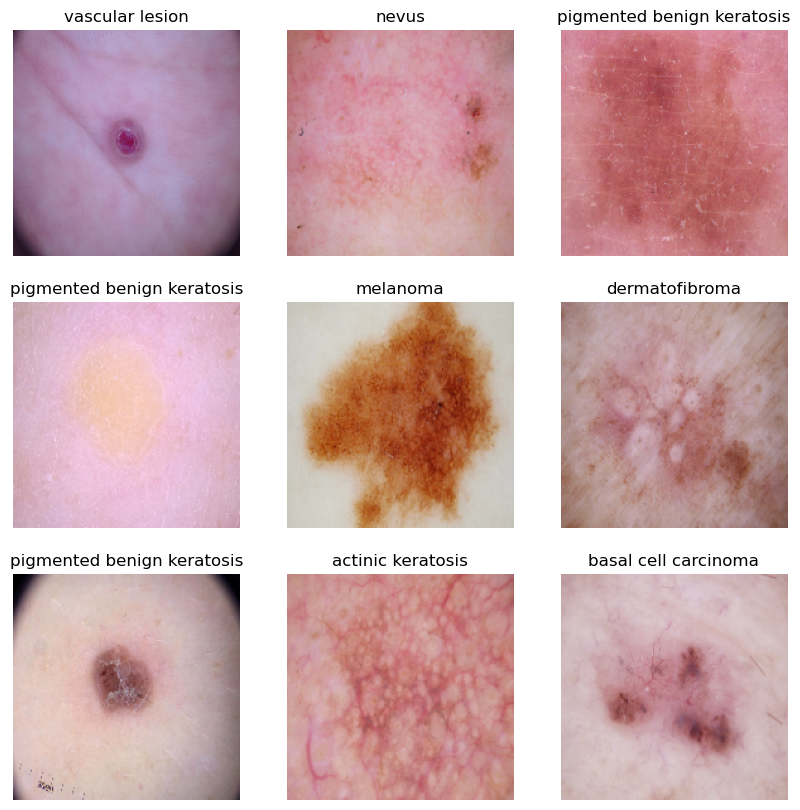

In [8]:
# Importing the matplotlib module:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Visualizing one instance from each of the classes:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Auto-Tuning the batches for faster training

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
# Applying autotune:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Model Building
- Creating  a CNN model, which can accurately detect 9 classes present in the dataset. 
- Using `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
# Importing the libraries required for Model Building:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,Rescaling

In [11]:
# Normalizing the iage data:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_normalized_ds= val_ds.map(lambda x, y: (normalization_layer(x), y))

In [12]:
# Checking if the normalization worked:
for images,labels in val_normalized_ds:
    X_train=images
    y_train=labels
X_train

<tf.Tensor: shape=(31, 180, 180, 3), dtype=float32, numpy=
array([[[[0.51584965, 0.37957516, 0.38104576],
         [0.48725492, 0.3284314 , 0.3156863 ],
         [0.5034314 , 0.33235297, 0.3424837 ],
         ...,
         [0.42679757, 0.32973897, 0.3321896 ],
         [0.41372553, 0.31176472, 0.32254905],
         [0.40228763, 0.30032685, 0.31176472]],

        [[0.52581704, 0.3728758 , 0.3784314 ],
         [0.51225495, 0.36176473, 0.3661765 ],
         [0.5259804 , 0.3763072 , 0.37908497],
         ...,
         [0.43611118, 0.33578447, 0.34477136],
         [0.4176471 , 0.3156863 , 0.32450983],
         [0.4006537 , 0.2986929 , 0.31013077]],

        [[0.5305556 , 0.3779412 , 0.39607847],
         [0.5411765 , 0.4009804 , 0.40539217],
         [0.536438  , 0.39558825, 0.4029412 ],
         ...,
         [0.4540852 , 0.3570266 , 0.35947722],
         [0.429902  , 0.3279412 , 0.33578435],
         [0.40620944, 0.30735326, 0.2941179 ]],

        ...,

        [[0.5253268 , 0.39820263,

### Model 1:

In [13]:

model=Sequential()

#layer1:

model.add(Conv2D(16,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(180,180,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer2:
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))



#layer3:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#layer4:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(9,activation='softmax'))

#### Model Compilation:

In [14]:
### Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Looking at the model summary:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 64)        0

### Train the model

In [16]:
# Training the model:
epochs =20
history = model.fit(
  train_normalized_ds,
  validation_data=val_normalized_ds,
  epochs=epochs,batch_size=32
)

Epoch 1/20
56/56 [==============================] - 28s 373ms/step - loss: 2.0296 - accuracy: 0.2137 - val_loss: 1.9054 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 19s 341ms/step - loss: 1.7641 - accuracy: 0.3761 - val_loss: 1.5409 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 19s 336ms/step - loss: 1.5328 - accuracy: 0.4777 - val_loss: 1.4533 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 18s 330ms/step - loss: 1.4234 - accuracy: 0.5011 - val_loss: 1.3847 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 19s 340ms/step - loss: 1.3049 - accuracy: 0.5357 - val_loss: 1.3909 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 20s 349ms/step - loss: 1.2578 - accuracy: 0.5536 - val_loss: 1.3562 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 18s 319ms/step - loss: 1.2102 - accuracy: 0.5642 - val_loss: 1.3658 - val_accuracy: 0.5034

### Visualizing training results

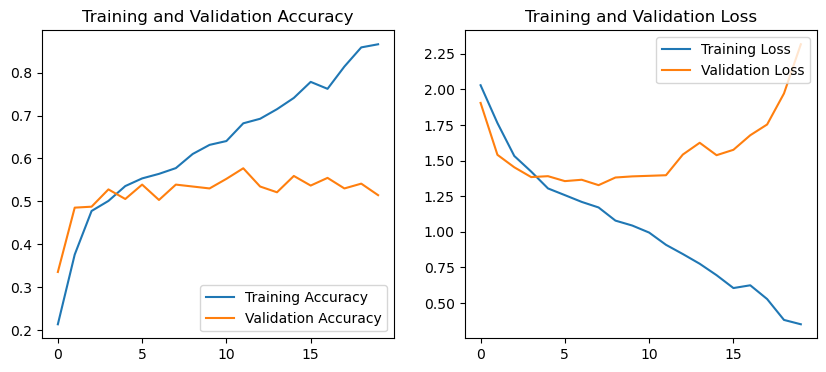

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The first model seems to be highly overfitting as the training accuracy is very high and the validation accuracy is stagnant at a low value:

### Model 2:


In [18]:
# To deal with overfitting we can use Data Augmentation to deal with it:#

# using Sequential method for augmentation:
data_augmentation=Sequential(
[layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(img_height,img_width,3)),
layers.experimental.preprocessing.RandomRotation(0.4),
layers.experimental.preprocessing.RandomZoom(0.3)])

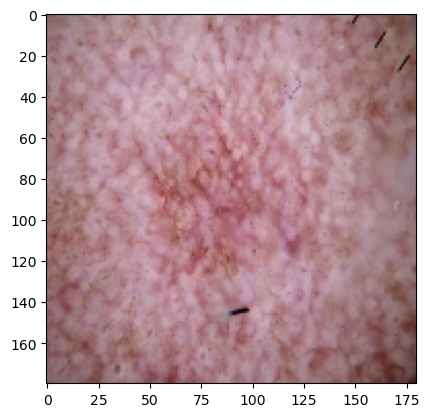

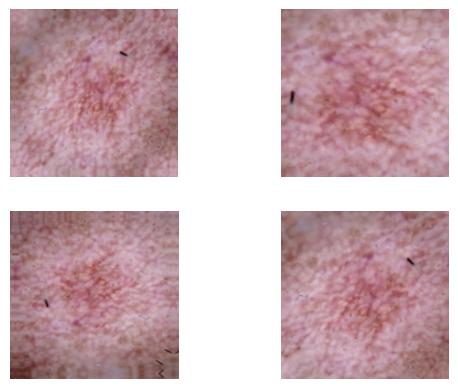

In [19]:
# visualizing how augmentation strategy works for one instance of training image.

plt.imshow(X_train[0])
plt.show()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(data_augmentation(X_train)[0])
    plt.axis('off')
plt.show()


### Data Augmentation simply creates more images using methods like rotation,cropping,flipping etc. However the ImageDataGenerator method doesn't allow us to control the number of samples we want to create which will be crucial in dealing with class imbalance. So we shall move ahead with Augmentor library of Python to deal with it.

In [20]:
## Using data Augmentation and  Dropout layer to check if there is any improvement in performance:


model=Sequential()

#layer1:
model.add(data_augmentation)
model.add(Conv2D(16,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(180,180,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#layer2:
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


#layer3:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


#layer4:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(9,activation='softmax'))



### Compiling the model

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [23]:
## Training the model for 20 epochs
epochs =20
history = model.fit(
  train_normalized_ds,
  validation_data=val_normalized_ds,
  epochs=epochs,batch_size=32
)

Epoch 1/20
56/56 [==============================] - 22s 379ms/step - loss: 2.1152 - accuracy: 0.1987 - val_loss: 2.1287 - val_accuracy: 0.2282
Epoch 2/20
56/56 [==============================] - 22s 385ms/step - loss: 1.9562 - accuracy: 0.2706 - val_loss: 2.0005 - val_accuracy: 0.2685
Epoch 3/20
56/56 [==============================] - 21s 383ms/step - loss: 1.7086 - accuracy: 0.3884 - val_loss: 1.7270 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 22s 395ms/step - loss: 1.6232 - accuracy: 0.4124 - val_loss: 1.6946 - val_accuracy: 0.4273
Epoch 5/20
56/56 [==============================] - 22s 389ms/step - loss: 1.5327 - accuracy: 0.4710 - val_loss: 1.5885 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 22s 389ms/step - loss: 1.4729 - accuracy: 0.4721 - val_loss: 1.4764 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 22s 394ms/step - loss: 1.4388 - accuracy: 0.4927 - val_loss: 1.4729 - val_accuracy: 0.4922

### Visualizing the results

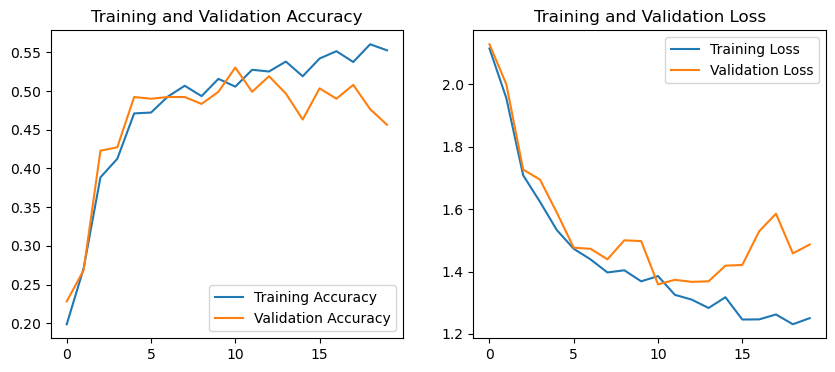

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### As can be seen from the above graphs that the model is still overfitting and there is hardly any improvement. Now in order to deal with overfitting we can move ahead with other means like Class Imbalance Handling.

### Trying data augmentation with the ImageDataGenrator method:

In [25]:
# To deal with overfitting we can use Data Augmentation to deal with it:
# There are two libraries to use Augmentation:
# - ImageDataGenerator
# - Augmentor

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
     featurewise_center=True,
     featurewise_std_normalization=True,
     rotation_range=20,
     width_shift_range=0.2,
     height_shift_range=0.2,
    fill_mode='nearest',
     horizontal_flip=True,
     validation_split=0.2)


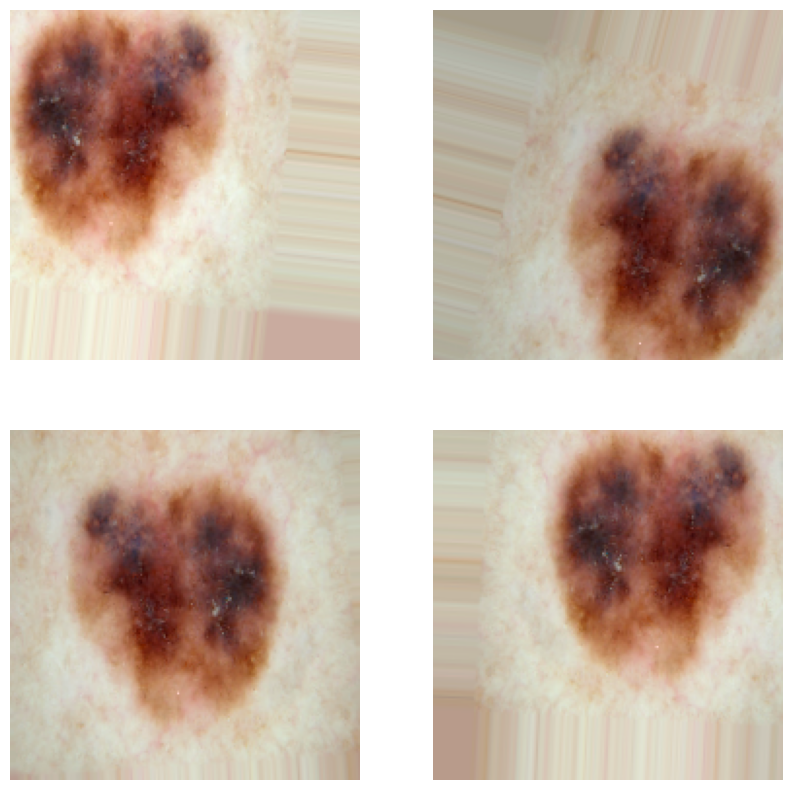

In [26]:
# visualizing how augmentation strategy works for one instance of training image.

from keras.preprocessing import image
classnames = [os.path.join(data_dir_train, fname) for fname in os.listdir(data_dir_train)]
classnames=classnames[1:]
fnames=[os.path.join(path,fname) for path in classnames for fname in os.listdir(path)]
img_path = fnames[3]
img = image.load_img(img_path, target_size=(180, 180))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
plt.figure(figsize=(10,10))
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2,2,i+1)
    
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break
plt.show()


## Class Imbalance Handling:

###  Finding the distribution of classes in the training dataset.
#####  Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Checking the number of images per class:
classnames = [os.path.join(data_dir_train, fname) for fname in os.listdir(data_dir_train)]
classnames=classnames[1:]
classes=os.listdir(data_dir_train)[1:]
fnames=[os.path.join(path,fname) for path in classnames for fname in os.listdir(path)]
for i in range(len(classnames)):
    print(classes[i],len(os.listdir(classnames[i])))

melanoma 439
pigmented benign keratosis 463
nevus 358
basal cell carcinoma 377
actinic keratosis 115
squamous cell carcinoma 182
vascular lesion 140
seborrheic keratosis 78
dermatofibroma 96



#### - As can be seen from above code, `pigmented benign keratosis` has most number of sample images.
#### - Classes like melanoma, pigmented benign keratosis, basal cell carcinoma etc dominate as compared to others.


#### Rectifying the class imbalance
####  Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
#Installing the library:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
# Defining the path:
path_to_training_dataset=str(data_dir_train)+'/'
path_to_training_dataset

'/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

In [30]:
# Importing the Augmentor object:
import Augmentor

#Instatiating a aumentor pipeline:
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x160ADCBD0>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x160ADCA90>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 438 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 357 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x160A6E4D0>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x160966650>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1654A9D90>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x160213BD0>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
## Checking the count
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
import os
import glob
# Making the list of paths for all the classes:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list

['/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010580.jpg_34031f87-960e-4822-9221-06e6efbe87d6.jpg',
 '/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010757.jpg_2f153749-0f97-40c4-853e-e6fe8c8c654a.jpg',
 '/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010355.jpg_c012ecf2-b9d6-4f20-b228-2e3a0135db7a.jpg',
 '/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010175.jpg_8ece063d-49d3-413a-9ffe-5803d09f8dba.jpg',
 '/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010631.jpg_f81fa6f0-cf8f-4e4f-81df-505bffb2770c.jpg',
 '/Users/rishismac/Downloads/Skin cancer ISIC

In [33]:
# List of all the cancer types and respective image paths:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [34]:
# Making a DataFrame:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [36]:
# Checking the number of images per class:
df2['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images if we want to improve training process.

### Training the model on the data created using Augmentor:

In [37]:
# Defining the non trainable parameters:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
data_dir_train

PosixPath('/Users/rishismac/Downloads/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

### Creating the training dataset

In [39]:
# Creating the new augmeted train tensor dataset:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
    label_mode='categorical',
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Creating the validation dataset

In [40]:
# Creating the validation tensor dataset:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
    label_mode='categorical',
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,Rescaling

# Applying normalization on the augmented dataset:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_normalized_ds= val_ds.map(lambda x, y: (normalization_layer(x), y))

In [42]:
# Checking if normalization worked:
for images,labels in val_normalized_ds:
    X_train=images
    y_train=labels
y_train

<tf.Tensor: shape=(3, 9), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

### Model 3:

In [43]:

### Your code goes here
model=Sequential()

#layer1:

model.add(Conv2D(16,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(180,180,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#layer2:
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


#layer3:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#layer4:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(9,activation='softmax'))



###  Compiling the model:

In [44]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
# Checking Model Summary:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 45, 45, 32)       

### Training the model:

In [46]:
epochs = 30
history = model.fit(
  train_normalized_ds,
  validation_data=val_normalized_ds,
  epochs=epochs,batch_size=32
)

Epoch 1/30
169/169 [==============================] - 72s 418ms/step - loss: 2.2812 - accuracy: 0.1358 - val_loss: 2.1824 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 69s 402ms/step - loss: 2.1609 - accuracy: 0.1714 - val_loss: 2.0875 - val_accuracy: 0.1834
Epoch 3/30
169/169 [==============================] - 70s 410ms/step - loss: 1.8156 - accuracy: 0.3118 - val_loss: 1.7175 - val_accuracy: 0.3549
Epoch 4/30
169/169 [==============================] - 71s 418ms/step - loss: 1.5246 - accuracy: 0.4138 - val_loss: 1.5705 - val_accuracy: 0.4395
Epoch 5/30
169/169 [==============================] - 76s 443ms/step - loss: 1.3654 - accuracy: 0.4694 - val_loss: 1.3882 - val_accuracy: 0.4922
Epoch 6/30
169/169 [==============================] - 79s 461ms/step - loss: 1.2681 - accuracy: 0.5187 - val_loss: 1.3106 - val_accuracy: 0.5026
Epoch 7/30
169/169 [==============================] - 75s 442ms/step - loss: 1.1751 - accuracy: 0.5580 - val_loss: 1.2086 - val_ac

###  Visualizing the model results:

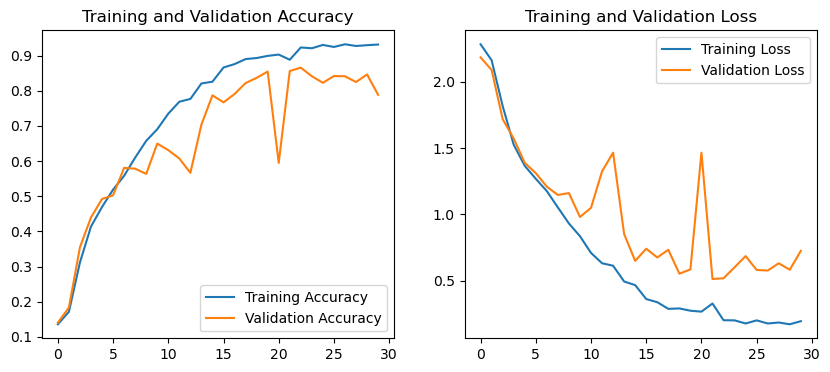

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### As can be seen from the above graphs, although there is some sign of overfitting but it is greatly reduced due to class imbalance handling.


### Model 4:

In [53]:
## Applying Batch Normalization and checking for improvement:

model=Sequential()

#layer1:

model.add(Conv2D(16,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(180,180,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#layer2:
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())


#layer3:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#layer4:
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())



#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))

# Output layer:
model.add(Dense(9,activation='softmax'))



In [54]:
# Compiling the model:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
# Checking the model summary:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 90, 90, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 45, 45, 32)       

In [56]:
# Fitting the model:
epochs = 30
history = model.fit(
  train_normalized_ds,
  validation_data=val_normalized_ds,
  epochs=epochs,batch_size=32
)

Epoch 1/30
169/169 [==============================] - 77s 446ms/step - loss: 1.9210 - accuracy: 0.3728 - val_loss: 4.5824 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 77s 452ms/step - loss: 1.3162 - accuracy: 0.5230 - val_loss: 8.0991 - val_accuracy: 0.1062
Epoch 3/30
169/169 [==============================] - 73s 425ms/step - loss: 1.0949 - accuracy: 0.6031 - val_loss: 5.0062 - val_accuracy: 0.2116
Epoch 4/30
169/169 [==============================] - 74s 432ms/step - loss: 0.8402 - accuracy: 0.7023 - val_loss: 3.0863 - val_accuracy: 0.3526
Epoch 5/30
169/169 [==============================] - 73s 425ms/step - loss: 0.7012 - accuracy: 0.7448 - val_loss: 3.2433 - val_accuracy: 0.3615
Epoch 6/30
169/169 [==============================] - 73s 427ms/step - loss: 0.5595 - accuracy: 0.7949 - val_loss: 2.6342 - val_accuracy: 0.3979
Epoch 7/30
169/169 [==============================] - 73s 427ms/step - loss: 0.4709 - accuracy: 0.8268 - val_loss: 1.8779 - val_ac

In [57]:

history_df=pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.921017,0.372774,4.582393,0.140312
1,1.316189,0.522997,8.099145,0.106162
2,1.094883,0.603116,5.006174,0.211581
3,0.840209,0.702337,3.086345,0.352635
4,0.701168,0.744807,3.243304,0.361544
5,0.559488,0.794881,2.634245,0.397921
6,0.470945,0.826780,1.877948,0.499629
7,0.393891,0.854414,2.183351,0.527097
8,0.347510,0.872033,2.500696,0.487751
9,0.306763,0.887982,1.597517,0.629547


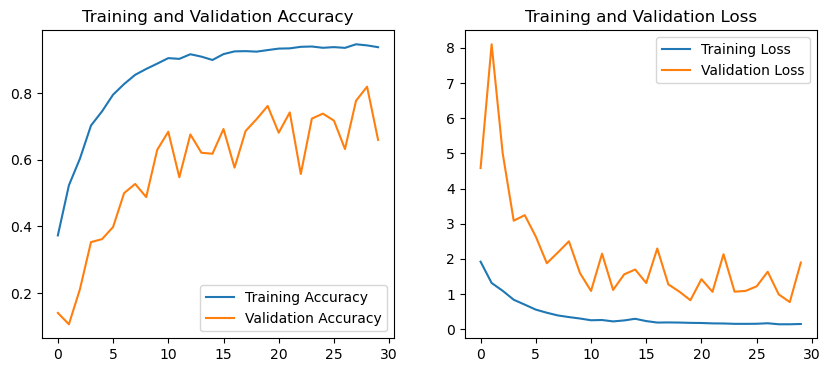

In [59]:
# Visualizing the Model results:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### As can be seen from above graph that the model becomes quite unstable and accuracy drops with batch normalization as compared to without normalization. 

## Conclusion: As compared to all the models, Model 3 turns out to be the best,which contains the imbalance handling and dropouts.
